# Questions 7 & 8

This script designs low pass Butterworth filters, of order varying from 4th to 8th, to meet a given specification. The script examines the stability of the filters and also the effects of 16-bit quantisation.

In [28]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from a2_config import A2_ROOT, SAVEFIG_CONFIG

### Filter Design

In [29]:
# Define filter specifications

F_S = 30    # sampling frequency, kHz
F_C =  3    # cutoff frequency, kHz

In [30]:
# Define utility functions for displaying frequency response and pole-zero plots
import scipy.signal as signal
from matplotlib.patches import Circle

def plot_freqz(w, h, fname=None):
    """Plot frequency response and overlay filter requirements."""
    fig, axs = plt.subplots(2, sharex=True, figsize=(6, 4))
    fig.tight_layout()
    sns.lineplot(x=w, y=np.abs(h), ax=axs[0])
    sns.lineplot(x=w, y=np.angle(h), ax=axs[1])
    # Axis labels
    axs[0].set_ylabel("Gain")
    axs[1].set_xlabel("Frequency (kHz)")
    axs[1].set_ylabel("Phase (rad)")
    axs[1].set_yticks([-np.pi, 0, np.pi])
    axs[1].set_yticklabels(["$-\pi$", "0", "$\pi$"])
    # Save or just show
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

def zplane(b, a, fname=None):
    """Plot poles and zeros from numerator and denominator of transfer function."""
    z, p, _ = signal.tf2zpk(b, a)
    fig, ax = plt.subplots(figsize=(5, 4))
    fig.tight_layout()
    ax.set_aspect("equal")
    # Axes and unit circle
    ax.add_patch(Circle((0, 0), 1, fill=False, color="k", ls=":", lw=0.5))
    ax.autoscale()
    ax.axhline(0, c="k", ls=":", lw=0.5)
    ax.axvline(0, c="k", ls=":", lw=0.5)
    # Poles and zeros
    color = sns.color_palette()[0]
    sns.scatterplot(x=z.real, y=z.imag, ax=ax, marker="o", 
                    edgecolor=color, facecolor="none")
    sns.scatterplot(x=p.real, y=p.imag, ax=ax, marker="x", lw=2)
    # Axis labels
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

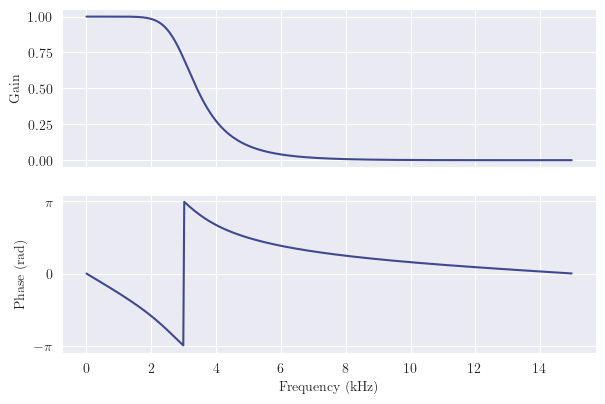

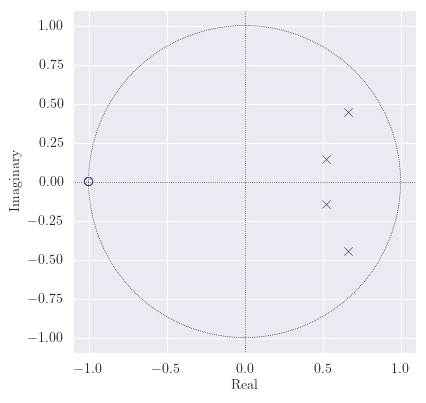

In [31]:
# Design 4th order Butterworth filter
b, a = signal.butter(4, F_C, btype="low", fs=F_S)
w, h = signal.freqz(b, a, fs=F_S)
plot_freqz(w, h, fname="q7_4th_freqz.png")
zplane(b, a, fname="q7_4th_zp.png")

In [32]:
# Quantize the transfer function coefficients to 16 bits (15-bit mantissa)

def quantize(x):
    """Returns the given array quantised to 16 bits (15-bit mantissa)."""
    # TODO: is the point just to round to 15 sig figs? If so, then just:
    #   x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + 14)
    norm_factor = 2 * max(np.abs(x))
    xq = np.abs(x) / norm_factor + 0.5
    xq = np.round(xq * (2 << 15)) / (2 << 15)
    xq = np.sign(x) * (xq - 0.5) * norm_factor
    return xq

def tf_quantize(b, a):
    """Returns the given transfer function coefficients quantised to 16 bits."""
    return quantize(b), quantize(a)

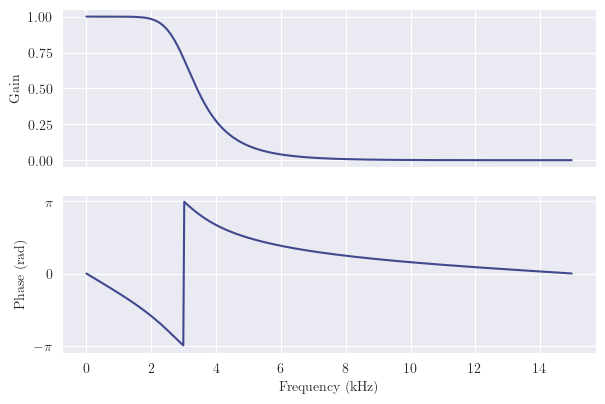

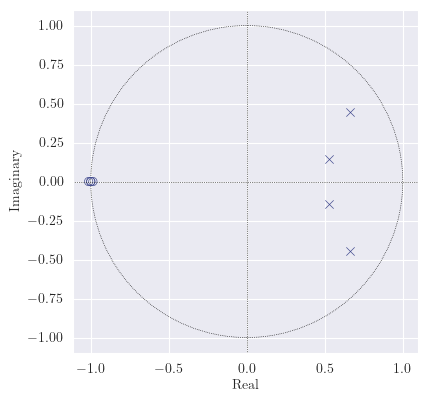

In [33]:
# Quantize coefficients of 4th-order filter and observe differences
bq, aq = tf_quantize(b, a)
wq, hq = signal.freqz(bq, aq, fs=F_S)
plot_freqz(wq, hq, fname="q7_q4th_freqz.png")
zplane(bq, aq, fname="q7_q4th_zp.png")

### Filter Testing

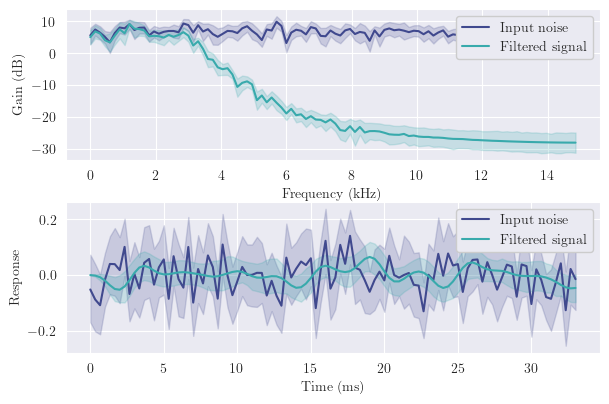

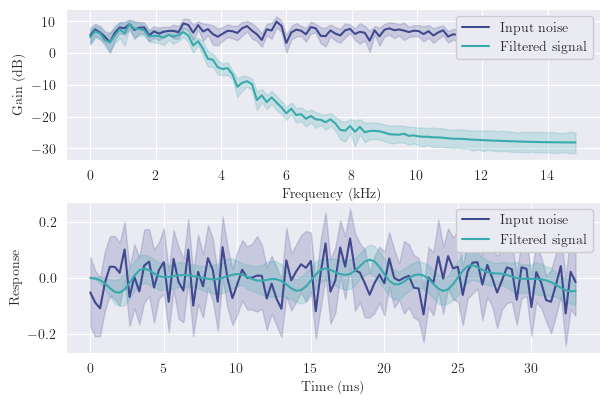

In [49]:
import pandas as pd
import scipy.fft as fft

# Helper function for converting frequency response to dB scale
dB = lambda x: 20 * np.log10(x)

def test_filter(b, a, n_trials=10, seed=0, fname=None):
    """
    Applies the filter to noise vectors and plots before and after time and
    frequency plots. Provides experimental insight into filter stability.
    """
    t = np.linspace(0, 100/3, 100, endpoint=False)
    f = fft.fftfreq(200, 1/F_S)[:100]
    ones = np.ones(100)
    agg = []
    np.random.seed(seed)
    for i in range(n_trials):
        x = np.random.rand(100) - 0.5
        z = signal.lfilter(b, a, x)
        xfft = dB(np.abs(fft.fft(x, n=200)[:100]))
        zfft = dB(np.abs(fft.fft(z, n=200)[:100]))
        agg.append(np.array([t, f, ones * i, xfft, zfft, x, z]))
    columns = ["Time", "Freq", "Trial", "FFT_In", "FFT_Out", "In", "Out"]
    agg = pd.DataFrame(np.hstack(agg).T, columns=columns)
    fig, axs = plt.subplots(2, figsize=(6, 4))
    fig.tight_layout()
    # Frequency plot
    sns.lineplot(data=agg, x="Freq", y="FFT_In", ax=axs[0], label="Input noise")
    sns.lineplot(data=agg, x="Freq", y="FFT_Out", ax=axs[0], label="Filtered signal")
    # Time plot
    sns.lineplot(data=agg, x="Time", y="In", ax=axs[1], label="Input noise")
    sns.lineplot(data=agg, x="Time", y="Out", ax=axs[1], label="Filtered signal")
    # Axis labels
    axs[0].set_xlabel("Frequency (kHz)")
    axs[0].set_ylabel("Gain (dB)")
    axs[0].legend(loc="upper right", framealpha=1)
    axs[1].set_xlabel("Time (ms)")
    axs[1].set_ylabel("Response")
    axs[1].legend(loc="upper right", framealpha=1)
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

# Test the filter on several zero-mean random sequences and plot the outputs
test_filter(bq, aq, n_trials=25, seed=42, fname="q7_4th_stability.png")
test_filter(bq, aq, n_trials=25, seed=42, fname="q7_q4th_stability.png")